<a href="https://colab.research.google.com/github/joaoflauzino/GI_Workshop/blob/main/MiniCurso_GI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Arquivos 
from google.colab import files
from google.colab import drive

# Pre-processamento
from imblearn.pipeline import Pipeline as pipe_imb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import sklearn

# Avaliação
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Visualização de dados 
import seaborn as sns
import matplotlib.pyplot as plt

# Problema

* Cenário de transações bancárias
* Muitos eventos de fraudes ocorrendo sem ação rápida para trativas

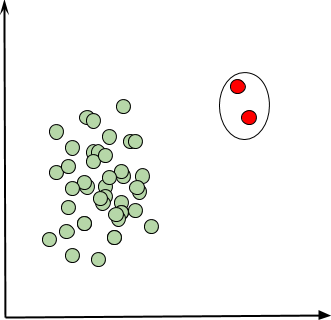

# Objetivo

* Ensinar a máquina para identificar fraude sem a necessidade de intervenção humana. Garantir que a máquina ela tenha exemplos suficientes do que é fraude e o que não é fraude.

* Aprendizado Supervisionado

# Descrição da base

- type -> CASH-IN (Depósito), CASH-OUT (Saque), DEBIT (Débito), PAYMENT (Pagamentos) e TRANSFER (Transferências)
- amount -> Valor da transação financeira
- nameOrig -> Cliente que iniciou a operação
- oldbalanceOrg -> Balanço inicial antes da transação
- newbalanceOrig -> Balanço atualizado após a transação
- nameDest -> cliente que recebeu o valor da transação
- oldbalanceDest -> Balanço inicial do cliente de destino que recebeu a transação
- newbalanceDest  -> Balanço atualizado do cliente de destino após a transação
- isFraud -> Marcação de qual transação é fraude
- IsFlaggedFraud -> Marcação realizada por um processo de negócios qualquer

## Leitura da base

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%time
df = pd.read_csv('/content/drive/My Drive/Datasets/Fraud.csv')

CPU times: user 8.04 s, sys: 1.16 s, total: 9.2 s
Wall time: 11.6 s


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.shape

(6362620, 11)

## Exploração dos dados 

In [7]:
# Definir um número de casas decimais
pd.set_option('float_format', '{:.2f}'.format)

In [8]:
%%time
# Básicas
df.describe()

CPU times: user 1.21 s, sys: 58.5 ms, total: 1.27 s
Wall time: 1.28 s


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [12]:
# Verificar os nulos
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [13]:
# Distribuição da nossa target
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [15]:
# Realizando cópia do dataframe
df_fraude = df.copy()

In [16]:
# Nome do destino
df_fraude['nameDest'].head()

0    M1979787155
1    M2044282225
2     C553264065
3      C38997010
4    M1230701703
Name: nameDest, dtype: object

In [20]:
# Criar lógica para identificar PF e PJ
df_fraude['identificacao'] = ''

df_fraude.loc[ df_fraude.nameOrig.str.contains('C')  & df_fraude.nameDest.str.contains('C'), 'identificacao'] = 'CC'
df_fraude.loc[ df_fraude.nameOrig.str.contains('C')  & df_fraude.nameDest.str.contains('M'), 'identificacao'] = 'CM'
df_fraude.loc[ df_fraude.nameOrig.str.contains('M')  & df_fraude.nameDest.str.contains('C'), 'identificacao'] = 'MC'
df_fraude.loc[ df_fraude.nameOrig.str.contains('M')  & df_fraude.nameDest.str.contains('M'), 'identificacao'] = 'MM'

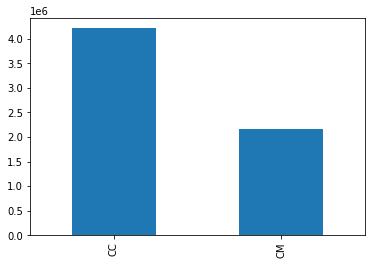

In [24]:
df_fraude['identificacao'].value_counts().plot.bar()

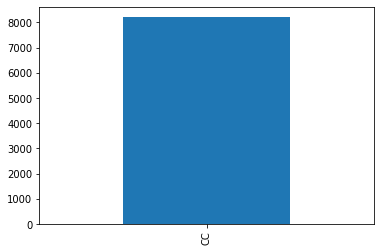

In [26]:
# Qual o tipo de conta que mais realiza fraude?
df_fraude.query('isFraud == 1')['identificacao'].value_counts().plot.bar()

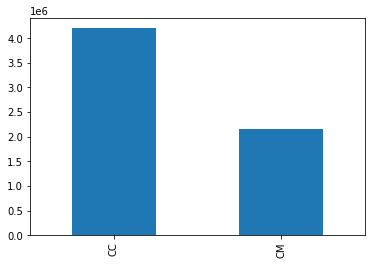

In [27]:
# Tipo de conta que não realiza fraude
df_fraude.query('isFraud == 0')['identificacao'].value_counts().plot.bar()

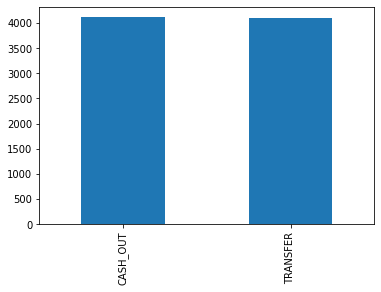

In [28]:
# Em quais tipos de transsações ocorrem fraudes?
df_fraude.query('isFraud == 1')['type'].value_counts().plot.bar()

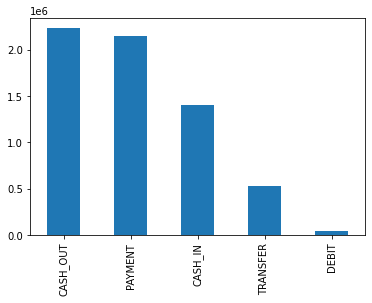

In [29]:
# Em quais tipos de transsações que não ocorrem fraudes?
df_fraude.query('isFraud == 0')['type'].value_counts().plot.bar()

In [31]:
# Será que a pessoa que realiza fraude sempre utiliza a mesma conta?
max(df_fraude.query('isFraud == 1')['nameOrig'].value_counts())

1

In [34]:
# Será que a pessoa que recebe o valor da fraude sempre utiliza a mesma conta?
max(df_fraude.query('isFraud == 1')['nameDest'].value_counts())

2

In [35]:
# Qual o valor antigo do balanço que mais repete quando se tem fraude?
df_fraude.query('isFraud == 1')['oldbalanceDest'].mode()

0   0.00
dtype: float64

- Análise bivariada/multivariada

# Preparar os dados para os modelos

In [38]:
df_fraude['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [39]:
df_fraude['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [40]:
# Excluir algumas variáveis
df_fraude = df_fraude.drop(['nameOrig', 'nameDest', 'identificacao', 'step', 'isFlaggedFraud'], axis = 1)

# Abordagem do modelo

In [ ]:
# X1 + X2 + X3 + X4 + XN ~ Y

In [44]:
X = df_fraude[[i for i in df_fraude.columns if i != 'isFraud']]

In [45]:
y = df_fraude['isFraud']

# Criação do nosso pipeline

In [68]:
# Pipeline para aplicar undersample
undersample_transformer = pipe_imb(steps=[('UndersampleTransformer', RandomUnderSampler())])

# Capturar variáveis numéricas
numerics = ['int64', 'float64']
numeric_features = [i for i in X.select_dtypes(include=numerics)]

# Pipeline para variáveis numéricas
numeric_transformer = Pipeline(steps = [('MinMaxScaler', MinMaxScaler())])

# Capturar variáveis categóricas
categorical_features = ['type']

# Pipeline para variáveis categóricas
categorical_transformer = Pipeline(steps=[('one_hot', OneHotEncoder(handle_unknown = "ignore"))])

# Concatenando pipelines
preprocessor = ColumnTransformer(
                  transformers=[
                                ('categorical', categorical_transformer, categorical_features),
                                ('num', numeric_transformer, numeric_features),
                                ])

# Algoritmos
algorithms = [tree.DecisionTreeClassifier(), sklearn.ensemble.GradientBoostingClassifier(), sklearn.ensemble.RandomForestClassifier()]

# Aplicando pipeline

- Aplicar o pipeline do undersample

In [70]:
# Aplicando
X_resampled, y_resampled = undersample_transformer.fit_resample(X, y)
# Transformando em dataframe
X_resampled_df = pd.DataFrame(X_resampled, columns = X.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [79]:
X_train, X_test, y_train, y_test =  train_test_split(X_resampled_df, y_resampled, test_size = 0.3)

# Aplicando pipeline

In [105]:
%%time
metricas_avaliacao = {'ROC': roc_auc_score(y_test, y_pred), 
                      'PRECISAO': precision_score(y_test, y_pred), 
                      'RECALL': recall_score(y_test, y_pred), 
                      'F1_SCORE': f1_score(y_test, y_pred) , 
                      'MTRIZ_CONFUSAO': confusion_matrix(y_test, y_pred)}
            
modelos = {}
for alg in algorithms:
  # Pipeline
  steps_ = [('preprocessor', preprocessor), ('models', alg)]
  # Concatenação
  model = Pipeline(steps=steps_)
  # Treinar nosso modelo
  model.fit(X_train, y_train)
  # Testar o modelo
  y_pred = model.predict(X_test)
  # Armazenar os resultados
  modelos[alg.__class__.__name__] = {}
  modelos[alg.__class__.__name__]['ROC'] = roc_auc_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['PRECISAO'] = precision_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['RECALL'] = recall_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['F1_SCORE'] = f1_score(y_test, y_pred)
  modelos[alg.__class__.__name__]['MATRIZ_CONFUSAO'] = confusion_matrix(y_test, y_pred)

CPU times: user 2.79 s, sys: 95 µs, total: 2.79 s
Wall time: 2.79 s


# Avaliando resultados

- Matriz de confusão

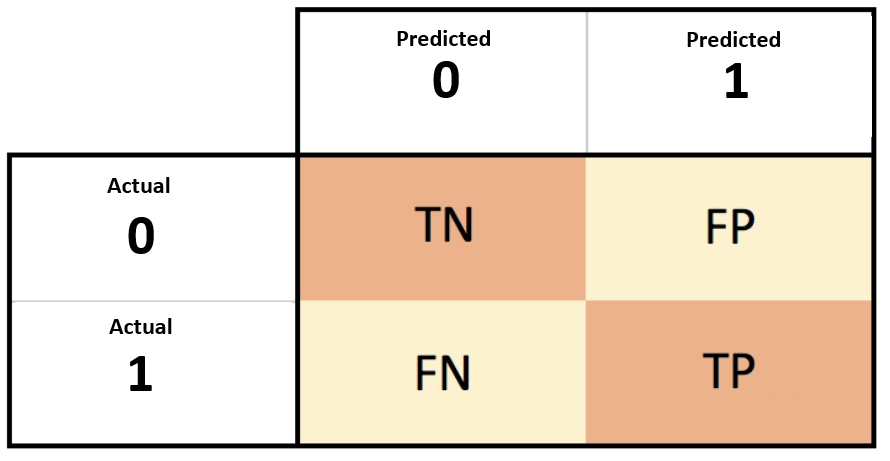

# Precisao -> tp / (tp + fp)
# Recall -> tp / (tp + fn)

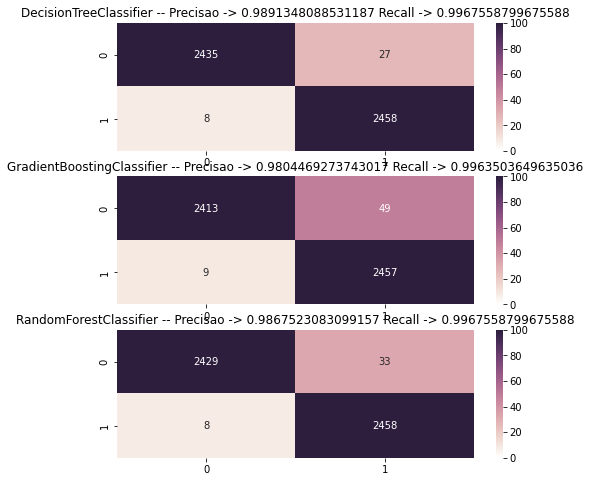

In [95]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

fig, axs = plt.subplots(nrows=len(algorithms), figsize=(8,8))

for indice, alg in enumerate(algorithms):
  sns.heatmap(modelos[alg.__class__.__name__]['MATRIZ_CONFUSAO'], annot=True, vmin=0.0, vmax=100.0, fmt='.0f', cmap=cmap, ax = axs[indice])
  axs[indice].set_title(f'{alg.__class__.__name__} -- Precisao -> {modelos[alg.__class__.__name__]["PRECISAO"]} Recall -> {modelos[alg.__class__.__name__]["RECALL"]}')

# Caso não desse certo, o que poderíamos fazer?

- Reunir com a equipe de negócios e verificar se existe mais variáveis
- Testar outros modelos
- Usar oversample ao invés de undersample ou utilizar modelos que saibam lidar com classes desbalanceadas
- Revisitar suas variáveis e criar outras
- Utilizar métodos para tunar seu modelo